In [2]:
%load_ext autoreload
%autoreload 2

# Extending the MAR experiments for hyperimpute paper

We study the paper _HymperImpute: Generalized Iterative Imputation with Automatic Model Selection_. In this paper, experiments are done by inducing artificial missingness (amputing) in a number of UCI datasets. In one scenario, they induce _MAR_ scenario by selecting a subset of variables as fully observed variables, and inducing missingness in the remaining ones using a logistic function of the fully observed variables. We describe the simulation details, and propose an extension based on PARCS functionality.

- The subset of fully observed features is selected randomly. We do the same in PARCS
- Rs are modeled by applying logistic function on linear models of fully observed variables. we can extend it in two ways: 1) randomize sigmoid parameters to deviate from standard sigmoid; 2) use gaussian RBF as another valid missing data model instead of sigmoid; 3) add nonlinear terms
- missingness indicators do not affect each other i.e. no R->R edge exists, even though such graph is still MAR. Using PARCS, we can gradually increase the R->R graph density and obtain the results

## gradually increasing R

In [3]:
import pandas as pd

data = pd.read_excel(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
)
# rename
data.rename({
    c: 'Z_{}'.format(i) for c, i in zip(data.columns, range(len(data.columns)))
}, axis=1, inplace=True)

# normalize
for c in data.columns:
    data[c] = (data[c] - data[c].mean()) / data[c].std()
data = data.round(3)

In [4]:
data.to_csv('normalized_data.csv', index=False)

## preparing PARCS

In [35]:
from parcs.helpers.missing_data import R_adj_matrix, indicator_graph_description_file, m_graph_convert
from parcs.graph_builder.randomizer import ConnectRandomizer
from parcs.cdag.graph_objects import Graph
import random as rand
import numpy as np
from time import time

# 0. configs
data = pd.read_csv('normalized_data.csv')
N = 1000  # number of samples
N_total = len(data.columns) # number of total variables
N_O = 3  # number of fully observed variables
miss_ratio = 0.3  # missing ratio in total

def get_miss_dataset(density_R=None):
    # 1. Write GDF for Z
    gdf = '# nodes\n'
    for c in data.columns:
        gdf += '{}: data(./normalized_data.csv)\n'.format(c)
    with open('gdf_Z.yml', 'w') as file:
        file.write(gdf)
    # 2. fully and partially observed variables
    obs_v = rand.sample(['Z_{}'.format(i) for i in range(N_total)], N_O)
    miss_v = list(set(data.columns) - set(obs_v))
    total_v = sorted(obs_v + miss_v)
    # 3. write GDF for R
    r_mask = R_adj_matrix(size=N_total-N_O, density=density_R)
    indicator_graph_description_file(
        adj_matrix=r_mask,
        node_names=miss_v,
        prefix='R',
        miss_ratio=miss_ratio,
        supress_asteriks=False,
        subscript_only=True,
        file_dir='./gdf_R.yml'
    )
    # 4. randomize
    rndz = ConnectRandomizer(
    parent_graph_dir='gdf_Z.yml',
    child_graph_dir='gdf_R.yml',
    guideline_dir='guideline.yml',
    adj_matrix_mask=pd.DataFrame(np.ones(shape=(N_total, N_total-N_O)),
                                 index=data.columns,
                                 columns=['R_{}'.format(i.split('_')[1]) for i in miss_v])
    )
    # 5. samples
    nodes, edges = rndz.get_graph_params()
    g = Graph(nodes=nodes, edges=edges)
    s = g.sample(N)

    # outputs
    gt = s[total_v]
    ds = m_graph_convert(s, missingness_prefix='R_', shared_subscript=True)
    return gt, ds[total_v]

0.0


/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.5
1.0


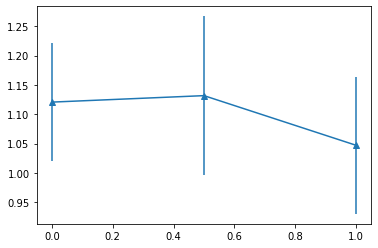

In [32]:
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt
from hyperimpute.plugins.imputers import Imputers

range_ = np.linspace(0, 1, 3)
rmse_mean = []
rmse_std = []
for r_density in range_:
    print(r_density)
    temp = []
    for it in range(10):
        gt, ds = get_miss_dataset(density_R=r_density)
        # kni = KNNImputer(n_neighbors=5)
        hpi = Imputers().get(
            'hyperimpute',
            optimizer='hyperband',
            classifier_seed=['logistic_regression'],
            regression_seed=['linear_regression']
        )
        imp = hpi.fit_transform(ds)
        temp.append(np.sqrt(np.sum(np.square(gt.values - imp.values))/N))
    rmse_mean.append(np.mean(temp))
    rmse_std.append(np.std(temp))

plt.errorbar(range_, rmse_mean, rmse_std, marker='^')
plt.show()

0.0


/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1.0


/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alireza/Desktop/projects/simulator/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means

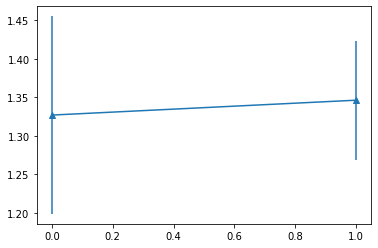

In [36]:
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt
from hyperimpute.plugins.imputers import Imputers

range_ = np.linspace(0, 1, 2)
rmse_mean = []
rmse_std = []
for r_density in range_:
    print(r_density)
    temp = []
    for it in range(10):
        gt, ds = get_miss_dataset(density_R=r_density)
        # kni = KNNImputer(n_neighbors=5)
        hpi = Imputers().get(
            'hyperimpute',
            optimizer='hyperband',
            classifier_seed=['logistic_regression'],
            regression_seed=['linear_regression']
        )
        imp = hpi.fit_transform(ds)
        temp.append(np.sqrt(np.sum(np.square(gt.values - imp.values))/N))
    rmse_mean.append(np.mean(temp))
    rmse_std.append(np.std(temp))

plt.errorbar(range_, rmse_mean, rmse_std, marker='^')
plt.show()